<a href="https://colab.research.google.com/github/Deeksha-Pandit/EVA4-S11/blob/master/S11_Trial3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**<h3>Install Albumentations and Apex librabies</h3>**

In [0]:
%matplotlib inline

In [2]:
!pip install -U git+https://github.com/albu/albumentations
!pip install --no-cache-dir git+https://github.com/NVIDIA/apex

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-a6gtynem
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-a6gtynem
     |████████████████████████████████| 634kB 7.4MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=65099 sha256=a80aea89abf9b23641af82f0004e950a72a4f4c7d9caaa374e10273e269750c1
  Stored in directory: /tmp/pip-ephem-wheel-cache-b9h3pfd9/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=ada6d2ab3b862a81b57f9ef3abcbe473aca27ac59279efd52e68426e62865286
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
  

**<h3>Mount Drive<h3>**

In [3]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import sys
folder = '/content/gdrive/My Drive/Session11'
sys.path.append(folder)

In [0]:
import torch
import Albumentation
import show_images
import my_model
import train_test
import evaluate
import GradCam
import lr_finder

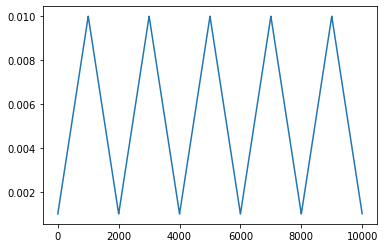

In [6]:
import matplotlib.pyplot as plt
import numpy as np

lr_plot=[]
def CyclicTriangle(iterations,minimum_lr,maximum_lr,step_size):
  for i in range(iterations):
    cycle = np.floor(1+i/(2*step_size))
    x = np.abs((i/step_size)-2*cycle+1)
    lr = minimum_lr + ((maximum_lr-minimum_lr)*(1-x))
    lr_plot.append(lr)
  plt.plot(list(range(iterations)),lr_plot)
CyclicTriangle(iterations=10000,minimum_lr=0.001,maximum_lr=0.01,step_size=1000)

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [7]:
classes, trainloader, testloader = Albumentation.album_Compose.load()

CUDA Available? True


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Let us show some of the training images, for fun.



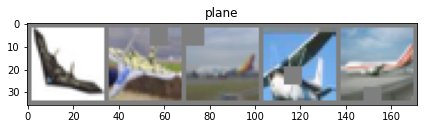

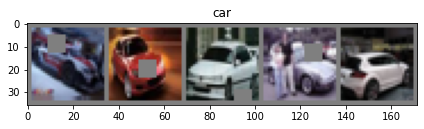

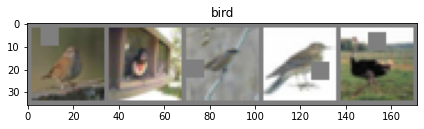

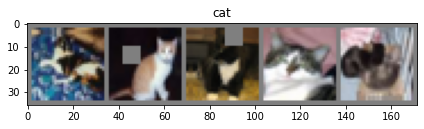

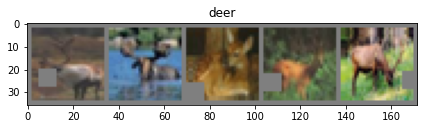

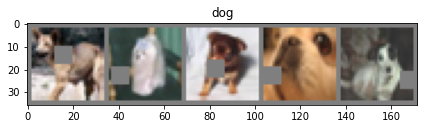

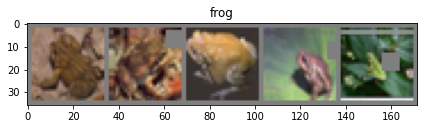

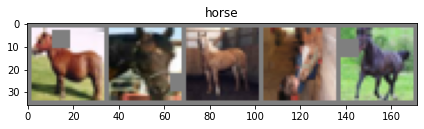

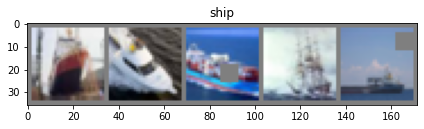

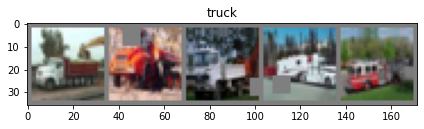

In [8]:
show_images.show_random_images(trainloader, classes)

In [9]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
resnet = my_model.ResNet().to(device)
summary(resnet, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1,

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


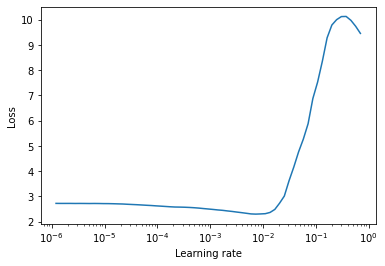

In [14]:
# LR finder fast ai approach
from lr_finder import LRFinder
import torch.optim as optim
import torch.nn as nn
L1lambda = 0
L2lambda = 1e-4
criterion = nn.NLLLoss()
optimizer = optim.SGD(resnet.parameters(), lr=1e-7, momentum=0.9, nesterov=True, weight_decay=L2lambda)
lr_finder = LRFinder(resnet, optimizer, criterion, device)
lr_finder.range_test(trainloader, end_lr=100, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [0]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

criterion = nn.NLLLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.01,momentum=0.9,weight_decay=0.005)
scheduler = OneCycleLR(optimizer, max_lr = 0.0125, total_steps=None, epochs=24, steps_per_epoch=1, pct_start=0.25, anneal_strategy='linear', cycle_momentum=False, base_momentum=0.8, max_momentum=0.9, div_factor=10.0,final_div_factor =1)

In [16]:
train_test.training(resnet,device,trainloader,testloader,optimizer,criterion,24,scheduler)

  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 1 LR: 0.00125


Loss=1.3494213819503784 Batch_id=97 Accuracy=42.00: 100%|██████████| 98/98 [00:24<00:00,  3.95it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 5342/10000 (53.42%)

EPOCH: 2 LR: 0.0035000000000000005


Loss=1.0346037149429321 Batch_id=97 Accuracy=59.04: 100%|██████████| 98/98 [00:25<00:00,  3.77it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0019, Accuracy: 6612/10000 (66.12%)

EPOCH: 3 LR: 0.005750000000000001


Loss=1.0087496042251587 Batch_id=97 Accuracy=68.34: 100%|██████████| 98/98 [00:26<00:00,  3.73it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0018, Accuracy: 6820/10000 (68.20%)

EPOCH: 4 LR: 0.008


Loss=0.7171610593795776 Batch_id=97 Accuracy=74.30: 100%|██████████| 98/98 [00:25<00:00,  3.86it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 7284/10000 (72.84%)

EPOCH: 5 LR: 0.01025


Loss=0.5688907504081726 Batch_id=97 Accuracy=78.19: 100%|██████████| 98/98 [00:25<00:00,  3.79it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0012, Accuracy: 7938/10000 (79.38%)

EPOCH: 6 LR: 0.0125


Loss=0.7259368300437927 Batch_id=97 Accuracy=80.12: 100%|██████████| 98/98 [00:26<00:00,  3.76it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 7771/10000 (77.71%)

EPOCH: 7 LR: 0.011875


Loss=0.4177740216255188 Batch_id=97 Accuracy=83.44: 100%|██████████| 98/98 [00:25<00:00,  3.79it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0012, Accuracy: 7878/10000 (78.78%)

EPOCH: 8 LR: 0.011250000000000001


Loss=0.42633965611457825 Batch_id=97 Accuracy=85.96: 100%|██████████| 98/98 [00:26<00:00,  3.76it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8482/10000 (84.82%)

EPOCH: 9 LR: 0.010625


Loss=0.3680282533168793 Batch_id=97 Accuracy=88.48: 100%|██████████| 98/98 [00:25<00:00,  3.78it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8236/10000 (82.36%)

EPOCH: 10 LR: 0.01


Loss=0.32270047068595886 Batch_id=97 Accuracy=89.64: 100%|██████████| 98/98 [00:25<00:00,  3.79it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8256/10000 (82.56%)

EPOCH: 11 LR: 0.009375


Loss=0.347587525844574 Batch_id=97 Accuracy=90.97: 100%|██████████| 98/98 [00:25<00:00,  3.79it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8501/10000 (85.01%)

EPOCH: 12 LR: 0.00875


Loss=0.30138516426086426 Batch_id=97 Accuracy=92.03: 100%|██████████| 98/98 [00:25<00:00,  3.78it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8742/10000 (87.42%)

EPOCH: 13 LR: 0.008125


Loss=0.17543908953666687 Batch_id=97 Accuracy=93.03: 100%|██████████| 98/98 [00:25<00:00,  3.77it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8708/10000 (87.08%)

EPOCH: 14 LR: 0.007500000000000001


Loss=0.15892785787582397 Batch_id=97 Accuracy=93.77: 100%|██████████| 98/98 [00:25<00:00,  3.77it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8687/10000 (86.87%)

EPOCH: 15 LR: 0.006875


Loss=0.1797253042459488 Batch_id=97 Accuracy=94.79: 100%|██████████| 98/98 [00:25<00:00,  3.80it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8786/10000 (87.86%)

EPOCH: 16 LR: 0.0062499999999999995


Loss=0.17815697193145752 Batch_id=97 Accuracy=95.31: 100%|██████████| 98/98 [00:25<00:00,  3.80it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8869/10000 (88.69%)

EPOCH: 17 LR: 0.005624999999999999


Loss=0.10764861106872559 Batch_id=97 Accuracy=96.05: 100%|██████████| 98/98 [00:25<00:00,  3.79it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8782/10000 (87.82%)

EPOCH: 18 LR: 0.005


Loss=0.11208804696798325 Batch_id=97 Accuracy=96.58: 100%|██████████| 98/98 [00:25<00:00,  3.77it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 8909/10000 (89.09%)

EPOCH: 19 LR: 0.004375


Loss=0.09480272233486176 Batch_id=97 Accuracy=97.17: 100%|██████████| 98/98 [00:25<00:00,  3.79it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9071/10000 (90.71%)

EPOCH: 20 LR: 0.00375


Loss=0.08615854382514954 Batch_id=97 Accuracy=97.54: 100%|██████████| 98/98 [00:25<00:00,  3.79it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 8919/10000 (89.19%)

EPOCH: 21 LR: 0.0031249999999999993


Loss=0.06592930853366852 Batch_id=97 Accuracy=98.02: 100%|██████████| 98/98 [00:26<00:00,  3.76it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 8973/10000 (89.73%)

EPOCH: 22 LR: 0.0025000000000000005


Loss=0.07574049383401871 Batch_id=97 Accuracy=98.36: 100%|██████████| 98/98 [00:25<00:00,  3.78it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9069/10000 (90.69%)

EPOCH: 23 LR: 0.001875


Loss=0.04297831654548645 Batch_id=97 Accuracy=98.79: 100%|██████████| 98/98 [00:25<00:00,  3.78it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Accuracy: 9128/10000 (91.28%)

EPOCH: 24 LR: 0.0012499999999999994


Loss=0.05170970410108566 Batch_id=97 Accuracy=98.88: 100%|██████████| 98/98 [00:25<00:00,  3.77it/s]



Test set: Average loss: 0.0005, Accuracy: 9160/10000 (91.60%)



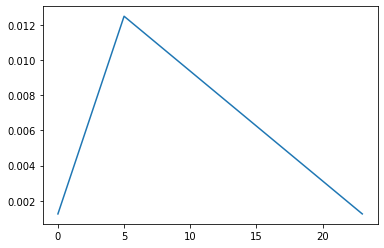

In [17]:
plt.plot(train_test.LR_list)

In [18]:
evaluate.evaluate_accuracy(resnet, device, testloader)

Accuracy of the network on the 10000 test images: 91.600 %


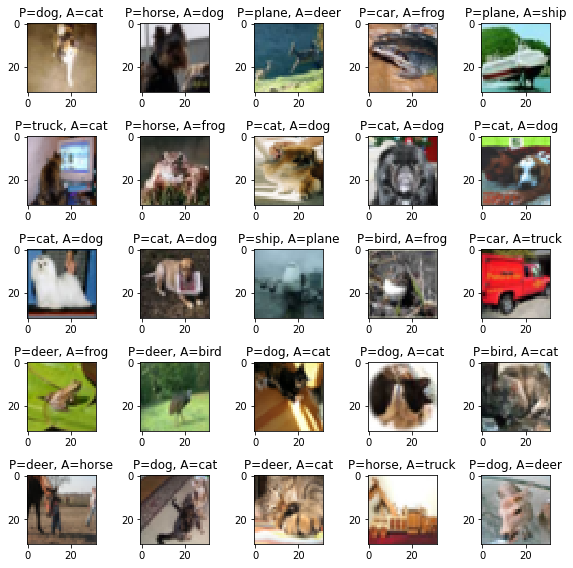

In [19]:
misclassified_images = evaluate.show_misclassified_images(resnet, device, testloader, classes)

In [20]:
evaluate.evaluate_classwise_accuracy(resnet, device, classes, testloader)

Accuracy of plane : 87 %
Accuracy of   car : 85 %
Accuracy of  bird : 100 %
Accuracy of   cat : 100 %
Accuracy of  deer : 100 %
Accuracy of   dog : 85 %
Accuracy of  frog : 87 %
Accuracy of horse : 100 %
Accuracy of  ship : 91 %
Accuracy of truck : 100 %


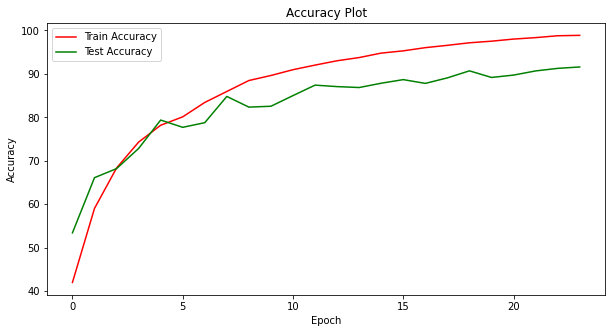

In [21]:
#import matplotlib.pyplot as plt
# fig, axs = plt.subplots(1,2, figsize=(15,10))

# axs[0].plot(train_acc)
# axs[0].plot(test_acc)
# axs[0].set_title("Accuracy Change")
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
ax.plot(train_test.train_acc_epoch_end,color = 'r',label="Train Accuracy")
ax.plot(train_test.test_acc,color = 'g',label="Test Accuracy")
ax.set(title="Accuracy Plot", xlabel="Epoch", ylabel="Accuracy")
ax.legend()
plt.show()

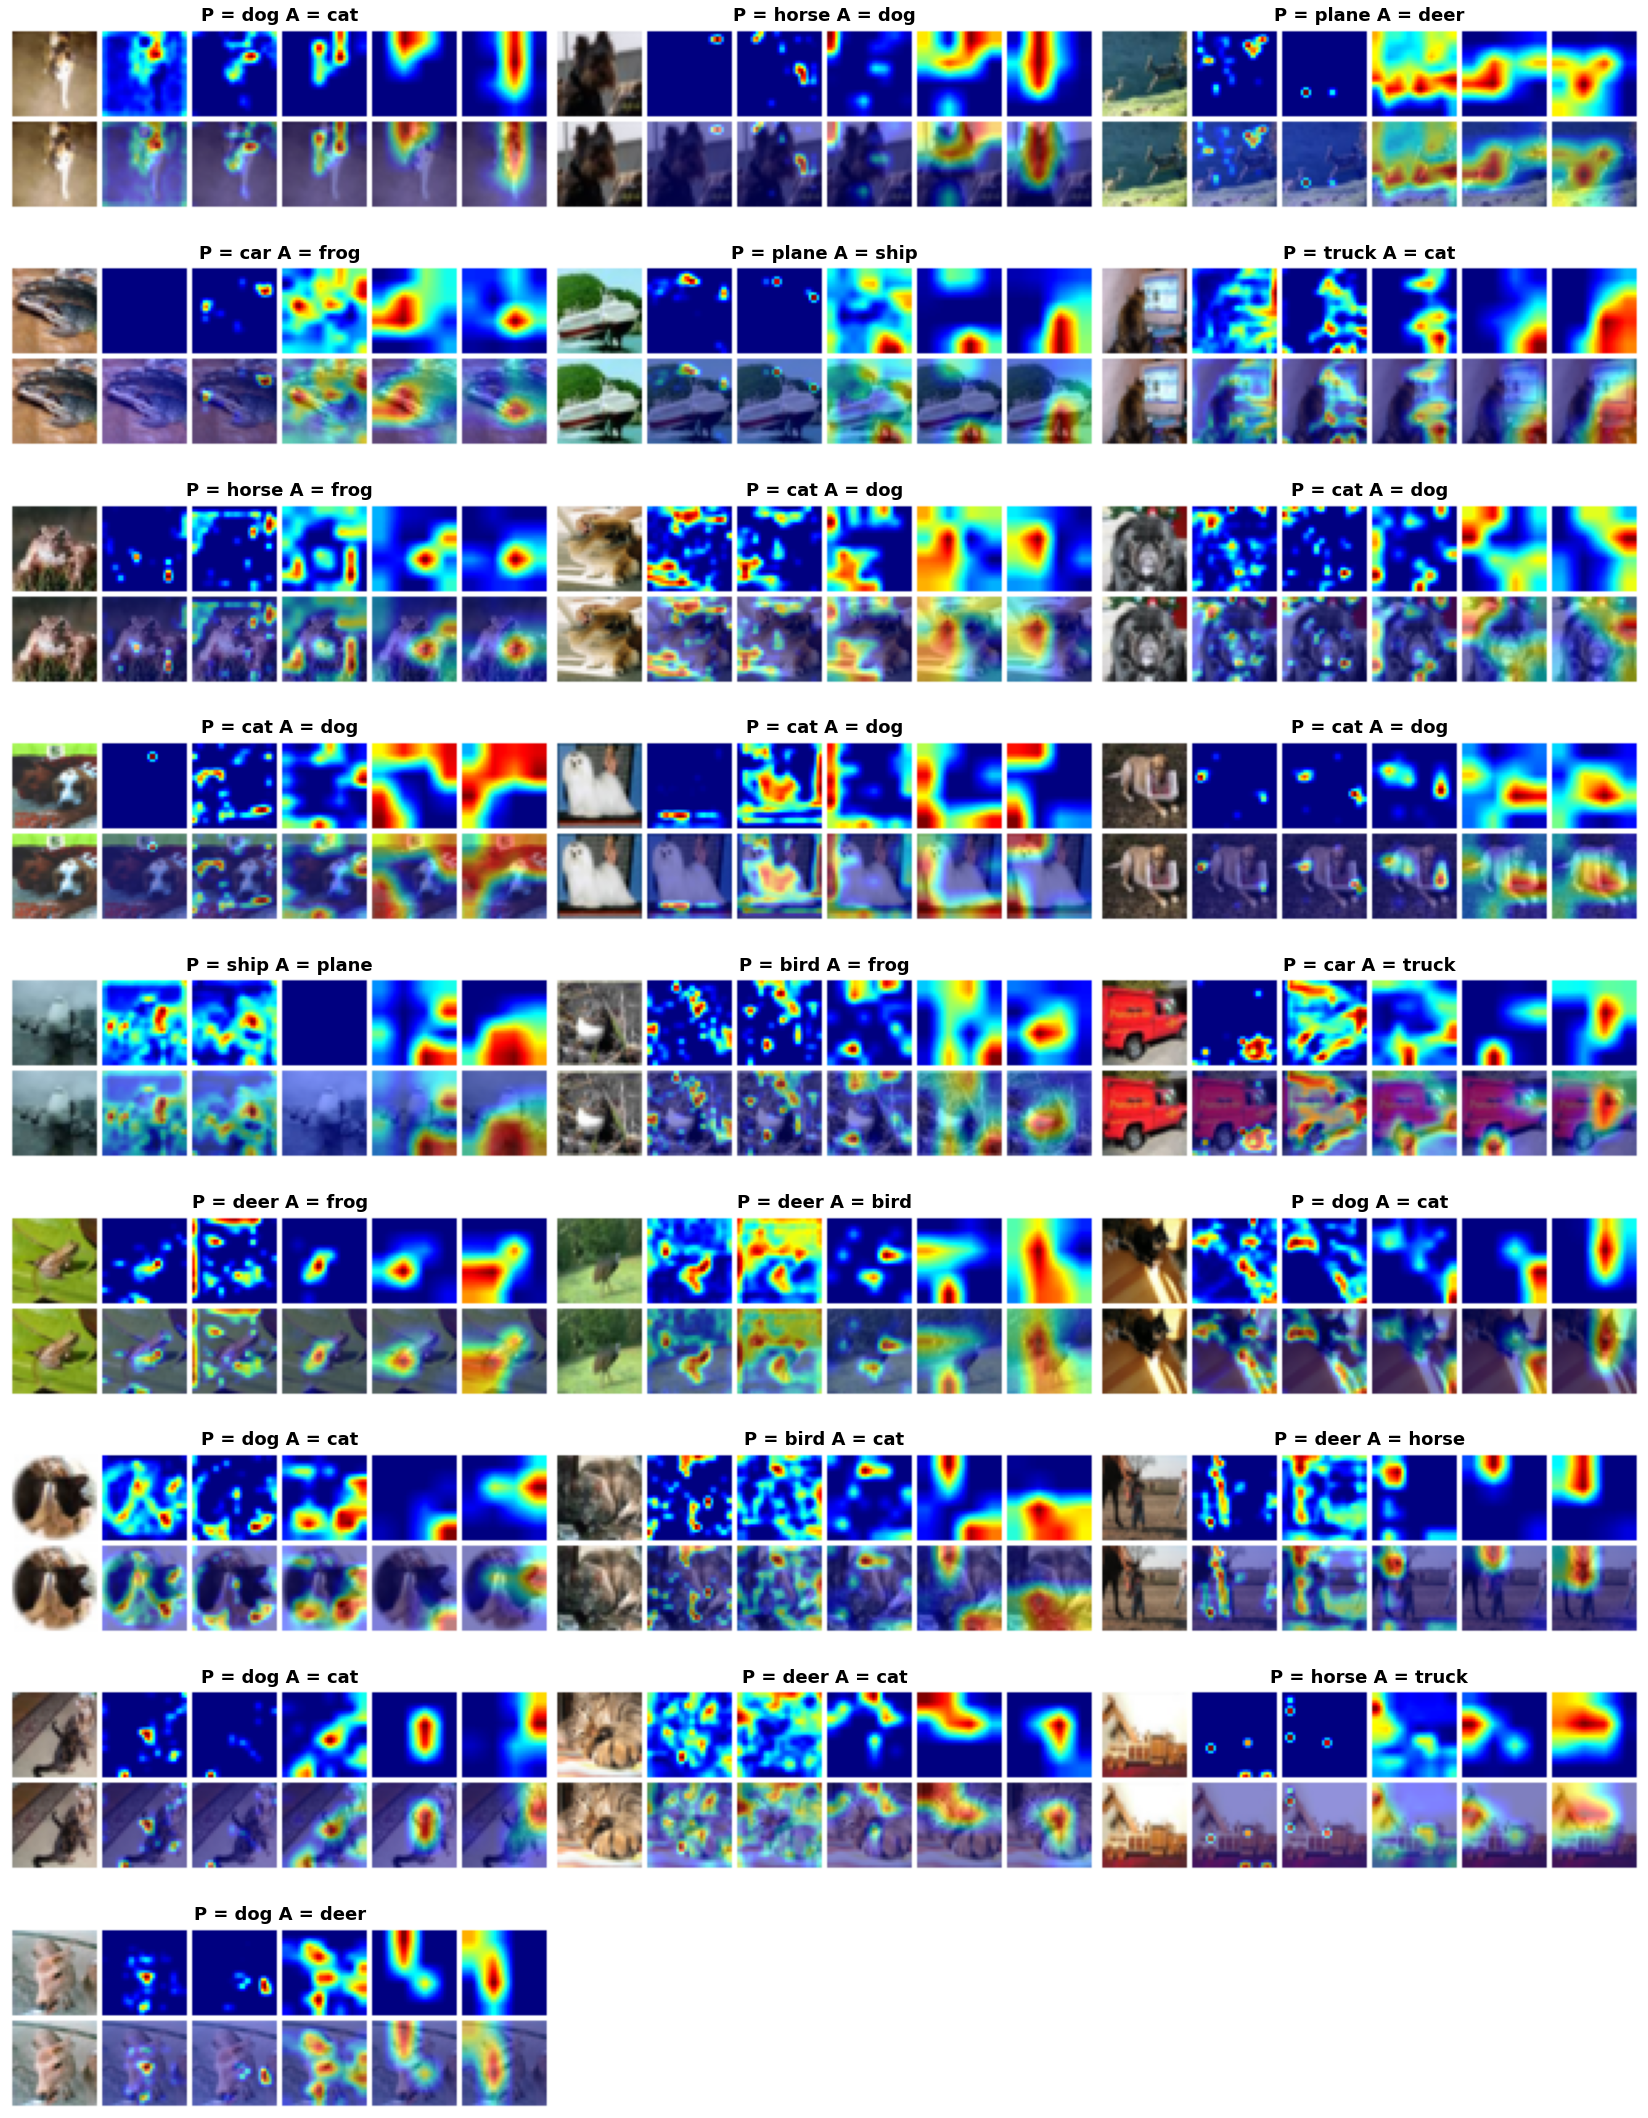

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from torchvision.utils import make_grid, save_image
fig = plt.figure(figsize=(23,30))
for i,k in enumerate(misclassified_images):
  images1 = [misclassified_images[i][0].cpu()/2+0.5]
  images2 =  [misclassified_images[i][0].cpu()/2+0.5]
  b = resnet.to(device)
  # output = model(misclassified_images[i][0])
  # _, predicted = torch.max(output.data, 1)
  #print(classes[int(predicted)])
  layers =  [resnet.convblock1,resnet.ResBlock_R1,resnet.layer2,resnet.convblock2,resnet.ResBlock_R2]
  for j in layers:
    g = GradCam.GradCAM(b,j)
    mask, _= g(misclassified_images[i][0].clone().unsqueeze_(0))
    heatmap, result = GradCam.GradCAM.visualize_cam(mask,misclassified_images[i][0].clone().unsqueeze_(0)/2+0.5 )
    images1.extend([heatmap])
    images2.extend([result])
  grid_image = make_grid(images1+images2,nrow=6,pad_value=1)
  npimg = grid_image.numpy()
  sub = fig.add_subplot(9, 3, i+1) 
 
  # fig.subplots_adjust(wspace=0)
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  sub.set_title('P = '+classes[int(misclassified_images[i][1])]+" A = "+classes[int(misclassified_images[i][2])],fontweight="bold",fontsize=18)
  sub.axis("off")
plt.tight_layout()
fig.subplots_adjust(wspace=0)